In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [715]:
def plot_miscoverage_examples(test_dataset, coverages, intervals):
    miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
    fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

    for ax in axs.flat:
        i = np.random.choice(miscovered_idx)
        ax.fill_between(range(test_dataset[i][1].size(0)),
                         intervals[i, 0].flatten().tolist(), 
                         intervals[i, 1].flatten().tolist(), 
                         color="r", alpha=0.25)
        ax.plot(intervals[i, 0].flatten().tolist(), linestyle="--", color="r")
        ax.plot(intervals[i, 1].flatten().tolist(), linestyle="--", color="r")
        ax.plot((intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist(), linestyle="--", linewidth=3, color="r")

        ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].flatten().tolist(), color="black")

        ax.set(xlabel='Time step', ylabel='Prediction')
    plt.show()
    
def plot_ts(dataset, coverages, intervals):
    miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 8), sharex=True)

    for ax in axs.flat:
        i = np.random.choice(miscovered_idx)
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        sequence, target = sequence[:length].flatten().tolist(), target.flatten().tolist()
        horizon = 
        
        # (Scatter)plot of the time series
        ax.scatter(range(length + 1, length + min(length, horizon) + 1), target, color="black")
        ax.plot(range(1, length+1), sequence, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + intervals[i, 0].flatten().tolist()
        upper = [sequence[-1]] + intervals[i, 1].flatten().tolist()
        pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()
        
        # Prediction start vertical
        ax.axvline(length, linestyle="--", color="black")
        
        ax.fill_between(range(length, length + min(length, horizon) + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + min(length, horizon) + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + min(length, horizon) + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + min(length, horizon)+ 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    #     print(axs)
    #     for ax in axs[0]:
    #         ax.set(xlabel='Time step')

    #     for ax in axs[:,0]:
    #         ax.set(ylabel='Prediction')

    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

## Generate datasets

In [577]:
from utils.make_data import generate_autoregressive_forecast_dataset
train_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20, periodicity=10)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20, periodicity=10)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=500, seq_len=100, horizon=20, periodicity=10)

## Conformal forecaster

In [581]:
from models.conformal import ConformalForecaster
model = ConformalForecaster(embedding_size=8, horizon=20, error_rate=0.05)
model.fit(train_dataset, calibration_dataset, epochs=2000, lr=0.01, batch_size=32)

Epoch: 0	Train loss: 1247.0431823730469
Epoch: 50	Train loss: 935.1598358154297
Epoch: 100	Train loss: 826.5782356262207
Epoch: 150	Train loss: 776.3818073272705
Epoch: 200	Train loss: 692.9773979187012
Epoch: 250	Train loss: 619.4629936218262
Epoch: 300	Train loss: 563.5280265808105
Epoch: 350	Train loss: 530.1461229324341
Epoch: 400	Train loss: 509.8603096008301
Epoch: 450	Train loss: 496.9078607559204
Epoch: 500	Train loss: 488.9519872665405
Epoch: 550	Train loss: 485.4331741333008
Epoch: 600	Train loss: 473.0249967575073
Epoch: 650	Train loss: 473.62461948394775
Epoch: 700	Train loss: 473.5164041519165
Epoch: 750	Train loss: 464.75479793548584
Epoch: 800	Train loss: 465.4668083190918
Epoch: 850	Train loss: 441.52321434020996
Epoch: 900	Train loss: 431.9111032485962
Epoch: 950	Train loss: 396.7220277786255
Epoch: 1000	Train loss: 373.0752363204956
Epoch: 1050	Train loss: 360.74969959259033
Epoch: 1100	Train loss: 354.41038513183594
Epoch: 1150	Train loss: 345.9373254776001
Epoch: 12

In [582]:
coverages, intervals = model.evaluate_coverage(test_dataset)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages.float(), dim=0).item()))

% of series within predicted intervals: 0.9620000123977661


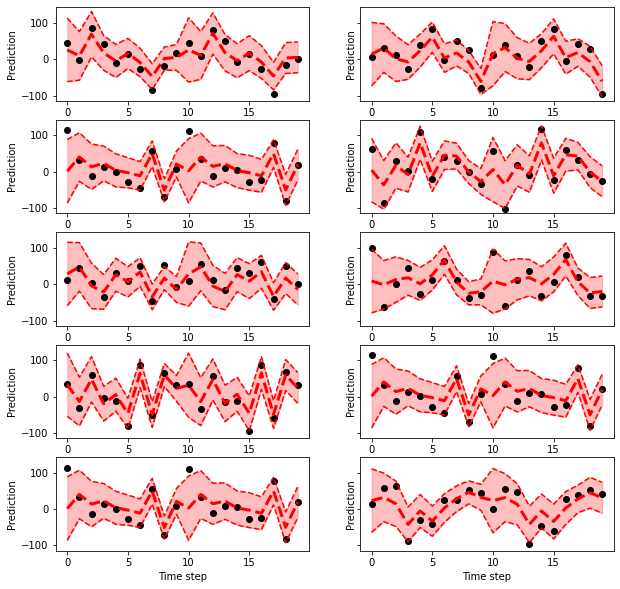

In [583]:
plot_miscoverage_examples(test_dataset, coverages, intervals)

## Shorter training intervals

Set `seq_len=10` and predict for horizon of 10 time steps.

In [599]:
noise_profile = [0.4, 1.2, 3.6, 10.8, 32.4]
train_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=20, horizon=10, periodicity=2, noise_profile=noise_profile)
calibration_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=20, horizon=10, periodicity=2, noise_profile=noise_profile)
test_dataset_short = generate_autoregressive_forecast_dataset(n_samples=500, seq_len=20, horizon=10, periodicity=2, noise_profile=noise_profile)

In [600]:
model_short = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)

In [601]:
model_short.fit(train_dataset_short, calibration_dataset_short, epochs=500, lr=0.01, batch_size=100)
coverages_short, intervals_short = model_short.evaluate_coverage(test_dataset_short)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages_short.float(), dim=0).item()))

Epoch: 0	Train loss: 865.05048828125
Epoch: 50	Train loss: 777.70966796875
Epoch: 100	Train loss: 748.9265991210938
Epoch: 150	Train loss: 736.9464599609375
Epoch: 200	Train loss: 727.8061340332031
Epoch: 250	Train loss: 727.9654541015625
Epoch: 300	Train loss: 720.7590942382812
Epoch: 350	Train loss: 719.097900390625
Epoch: 400	Train loss: 719.4460754394531
Epoch: 450	Train loss: 718.8731506347656
% of series within predicted intervals: 0.9300000071525574


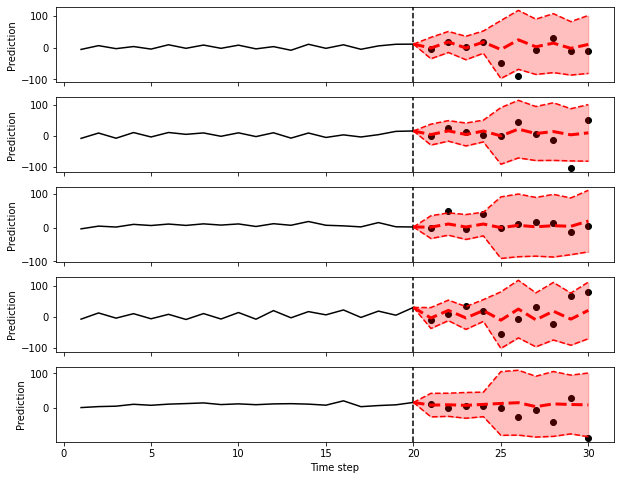

In [718]:
plot_ts(test_dataset_short, coverages_short, intervals_short, 10)

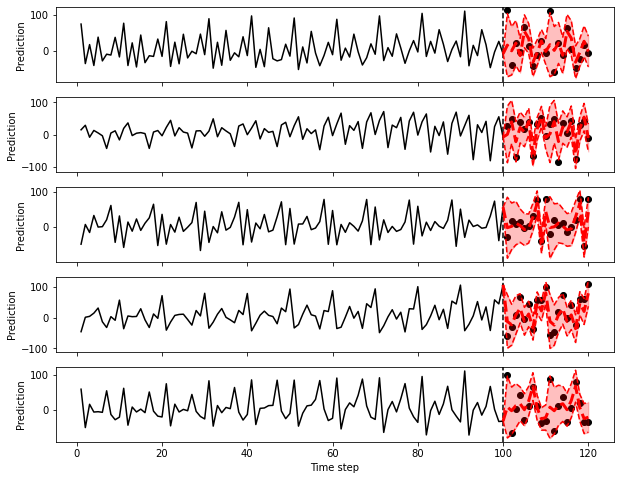

In [716]:
plot_ts(test_dataset, coverages, intervals, 20)